In [3]:
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from pathlib import Path
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

%load_ext autoreload
%autoreload 2

In [4]:
# Mac OS, runs faster on CPU. Possibly beacuse of the small batch size and the subsequent non parallelization of the GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [5]:
def file_iterator():
    data_dir = Path('dependency_treebank')
    for data_file in filter(lambda f: os.path.isfile(data_dir/f) and f.endswith('.dp'), os.listdir(data_dir)):
        yield data_dir/data_file

In [6]:
train_set = []
test_set = []
val_set = []

train_split = 100
val_split = 150

file_counter = 0
for file in file_iterator():
    file_counter += 1
    if file_counter <= train_split:
        train_set.append(pd.read_csv(file, sep="\t", names=['token', 'pos'], usecols=[0, 1], engine='python'))
    elif file_counter <= val_split:
        val_set.append(pd.read_csv(file, sep="\t", names=['token', 'pos'], usecols=[0, 1], engine='python'))
    else:
        test_set.append(pd.read_csv(file, sep="\t", names=['token', 'pos'], usecols=[0, 1], engine='python'))

assert len(train_set) == 100
assert len(val_set) == 50
assert len(test_set) == 49

In [7]:
train_frame = pd.concat(train_set)
test_frame = pd.concat(test_set)
val_frame = pd.concat(val_set)

assert sum([e.shape[0] for e in train_set]) == train_frame.shape[0]
assert sum([e.shape[0] for e in test_set]) == test_frame.shape[0]
assert sum([e.shape[0] for e in val_set]) == val_frame.shape[0]

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

# Tokenizer.from_pretrained('bert-base-uncased')
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_frame['token'].values)
vocab_size = len(tokenizer.word_index) + 1

encoded_doc = tokenizer.texts_to_sequences(train_frame['token'].values)

# Not necessary since we encode words and not sentences 
max_length = 1
padded_docs = pad_sequences(encoded_doc, maxlen=max_length, padding='post')

In [9]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [10]:
# create a weight matrix for words in training docs
# use 0 embedding as placeholder
embedding_matrix = zeros((vocab_size, 100))
c = 0
for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector
	else:
		c+=1
	#TODO: Add edgecase OOV

print(f"Encountered {c} OOV tokens")

Encountered 71 OOV tokens


In [11]:
# One hot encode train_frame['pos'].values
encoder = LabelEncoder()
encoder.fit(train_frame['pos'].values)
encoded_Y = encoder.transform(train_frame['pos'].values)
# convert integers to dummy variables (i.e. one hot encoded)
labels = np_utils.to_categorical(encoded_Y)

In [12]:
from tensorflow import keras
# define model
model = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=1, trainable=False)
model.add(e)
model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=64), input_shape=(None, 50)))
model.add(Dense(44, activation='softmax'))
# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

2022-12-07 18:21:01.852203: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 100)            632700    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dense (Dense)               (None, 44)                5676      
                                                                 
Total params: 722,856
Trainable params: 90,156
Non-trainable params: 632,700
_________________________________________________________________
None


In [13]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('log/log_lstm_64.csv', append=False, separator=';')

# fit the model
model.fit(padded_docs, labels, epochs=25, callbacks=csv_logger)

Epoch 1/25
1413/1413 [==============================] - 8s 3ms/step - loss: 1.1226 - accuracy: 0.6992
Epoch 2/25
1413/1413 [==============================] - 4s 3ms/step - loss: 0.6184 - accuracy: 0.8067
Epoch 3/25
1413/1413 [==============================] - 4s 3ms/step - loss: 0.5354 - accuracy: 0.8237
Epoch 4/25
1413/1413 [==============================] - 4s 3ms/step - loss: 0.4903 - accuracy: 0.8338
Epoch 5/25
1413/1413 [==============================] - 5s 3ms/step - loss: 0.4626 - accuracy: 0.8397
Epoch 6/25
1413/1413 [==============================] - 5s 3ms/step - loss: 0.4420 - accuracy: 0.8450
Epoch 7/25
1413/1413 [==============================] - 5s 3ms/step - loss: 0.4283 - accuracy: 0.8466
Epoch 8/25
1413/1413 [==============================] - 4s 3ms/step - loss: 0.4170 - accuracy: 0.8489
Epoch 9/25
1413/1413 [==============================] - 5s 3ms/step - loss: 0.4084 - accuracy: 0.8498
Epoch 10/25
1413/1413 [==============================] - 4s 3ms/step - loss: 0.401

1413/1413 [==============================] - 5s 4ms/step - loss: 0.3473 - accuracy: 0.8646
Train set accuracy: 86.46 %


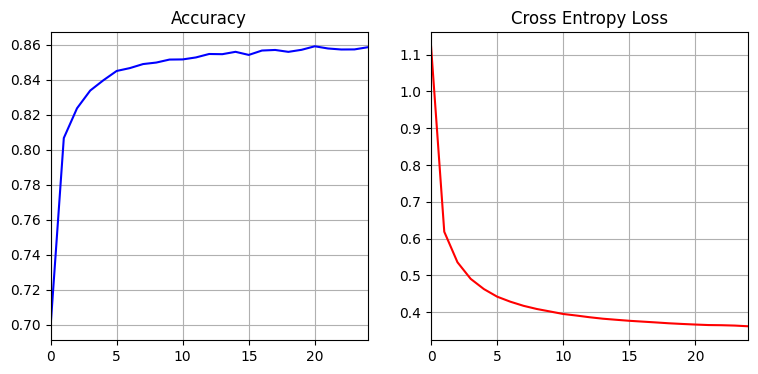

In [15]:
import my_plot

# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels)

print('Train set accuracy: {a:.2f} %'.format(a=accuracy*100))

my_plot.plot_log_results('log_lstm_64.csv')

In [11]:
# Using GRU instead of LSTM
# define model
model = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=1, trainable=False)
model.add(e)
# A
model.add(keras.layers.Bidirectional(keras.layers.GRU(units=128), input_shape=(None, 50)))
model.add(Dense(44, activation='softmax'))
# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

# fit the model
model.fit(padded_docs, labels, epochs=50)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels)
print('Accuracy: %f' % (accuracy*100))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1, 100)            632700    
                                                                 
 bidirectional_2 (Bidirectio  (None, 512)              549888    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 44)                22572     
                                                                 
Total params: 1,205,160
Trainable params: 572,460
Non-trainable params: 632,700
_________________________________________________________________
None
Epoch 1/50
1413/1413 [==============================] - 5s 2ms/step - loss: 0.8852 - accuracy: 0.7417
Epoch 2/50
1413/1413 [==============================] - 3s 2ms/step - loss: 0.5811 - accuracy: 0.8107
Epoch 3/50
1413/1413 [=======

In [19]:
# Use additional LSTM layer
# define model
model = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=1, trainable=False)
model.add(e)
# A
model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=128, return_sequences=True), input_shape=(None, 50)))
model.add(keras.layers.LSTM(128))
model.add(Dense(44, activation='softmax'))
# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

# fit the model
model.fit(padded_docs, labels, epochs=50)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels)
print('Accuracy: %f' % (accuracy*100))

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 1, 100)            632700    
                                                                 
 bidirectional_10 (Bidirecti  (None, 1, 256)           234496    
 onal)                                                           
                                                                 
 lstm_14 (LSTM)              (None, 128)               197120    
                                                                 
 dense_3 (Dense)             (None, 44)                5676      
                                                                 
Total params: 1,069,992
Trainable params: 437,292
Non-trainable params: 632,700
_________________________________________________________________
None
Epoch 1/50
1413/1413 [==============================] - 6s 3ms/step - loss: 0.9629 - accuracy: 0.7225

In [23]:
# Use additional Dense layer
from tensorflow import keras
# define model
model = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=1, trainable=False)
model.add(e)
model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=128), input_shape=(None, 50)))
model.add(Dense(128))
model.add(Dense(44, activation='softmax'))
# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

# fit the model
model.fit(padded_docs, labels, epochs=50)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels)
print('Accuracy: %f' % (accuracy*100))

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 1, 100)            632700    
                                                                 
 bidirectional_13 (Bidirecti  (None, 256)              234496    
 onal)                                                           
                                                                 
 dense_23 (Dense)            (None, 128)               32896     
                                                                 
 dense_24 (Dense)            (None, 44)                5676      
                                                                 
Total params: 905,768
Trainable params: 273,068
Non-trainable params: 632,700
_________________________________________________________________
None
Epoch 1/50
1413/1413 [==============================] - 4s 2ms/step - loss: 0.8624 - accuracy: 0.7429
